## 1. Hog Feature Extraction

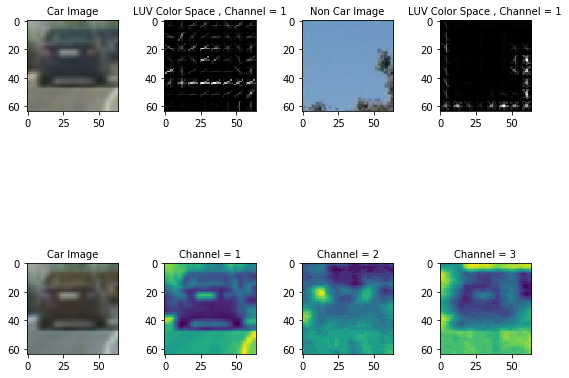

In [61]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
from scipy.ndimage.measurements import label
from skimage.feature import hog
%matplotlib inline

save_path = 'Example_images/'

pix_per_cell = 8
cell_per_block = 2
orient = 8

img = cv2.imread('vehicles/GTI_Far/image0001.png')
img1 = cv2.imread('non-vehicles/Extras/extra1.png')

#LUV Color Space , Channel = 'L'
features, hog_image = hog(cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0], orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")

features1, hog_image1 = hog(cv2.cvtColor(img1, cv2.COLOR_BGR2LUV)[:,:,0], orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")

#RGB Color Space , Channel = 'B'
features2, hog_image2 = hog(img[:,:,0], orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")

features2, hog_image3 = hog(img1[:,:,0], orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")


f, ax = plt.subplots(2, 4, figsize=(7, 7))
f.tight_layout()
ax[0][0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax[0][0].set_title('Car Image', fontsize=10)
ax[0][1].imshow(hog_image, cmap='gray')
ax[0][1].set_title('LUV Color Space , Channel = 1', fontsize=10)
ax[0][2].imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
ax[0][2].set_title('Non Car Image', fontsize=10)
ax[0][3].imshow(hog_image1, cmap='gray')
ax[0][3].set_title('LUV Color Space , Channel = 1', fontsize=10)

ax[1][0].imshow(img)
ax[1][0].set_title('Car Image', fontsize=10)
ax[1][1].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2LUV)[:,:,0])
ax[1][1].set_title('Channel = 1', fontsize=10)

ax[1][2].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2LUV)[:,:,1])
ax[1][2].set_title('Channel = 2', fontsize=10)
ax[1][3].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2LUV)[:,:,2])
ax[1][3].set_title('Channel = 3', fontsize=10)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(save_path + 'hog_feature.jpg')

## 2.0 Extract Images 

In [62]:
'''
Function to fetch images from folders as per given by udacity
'''
def fetch_images(img_type,folder_names):
    all_images_here = []
    #print(img_type)
    for folder in folder_names:
        images = glob.glob(img_type + '/' + folder + '/*.png')
        for image in images:
            all_images_here.append(image)
        #print(len(images))
    return all_images_here

img_types = ['vehicles','non-vehicles']
car_img_folders = ['GTI_Far','GTI_Left','GTI_MiddleClose','GTI_Right','KITTI_extracted']
non_car_img_folders = ['Extras','GTI']
cars = []
non_cars = []
cars = fetch_images(img_types[0],car_img_folders)
non_cars = fetch_images(img_types[1],non_car_img_folders)


## 2.1 Feature Extraction

In [67]:
'''
EXTRACTING Features
'''

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [68]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

  0%|          | 0/8792 [00:00<?, ?it/s]/Users/carnot/Public/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████| 8968/8968 [00:42<00:00, 210.23it/s]


## 2.2 Feature Transforming and scaling

In [69]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


## 2.3 Training and testing SVM classifier

In [70]:
# Use a linear SVC 
svc = LinearSVC(loss='hinge')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


7.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9814


## 3. Sliding Window 

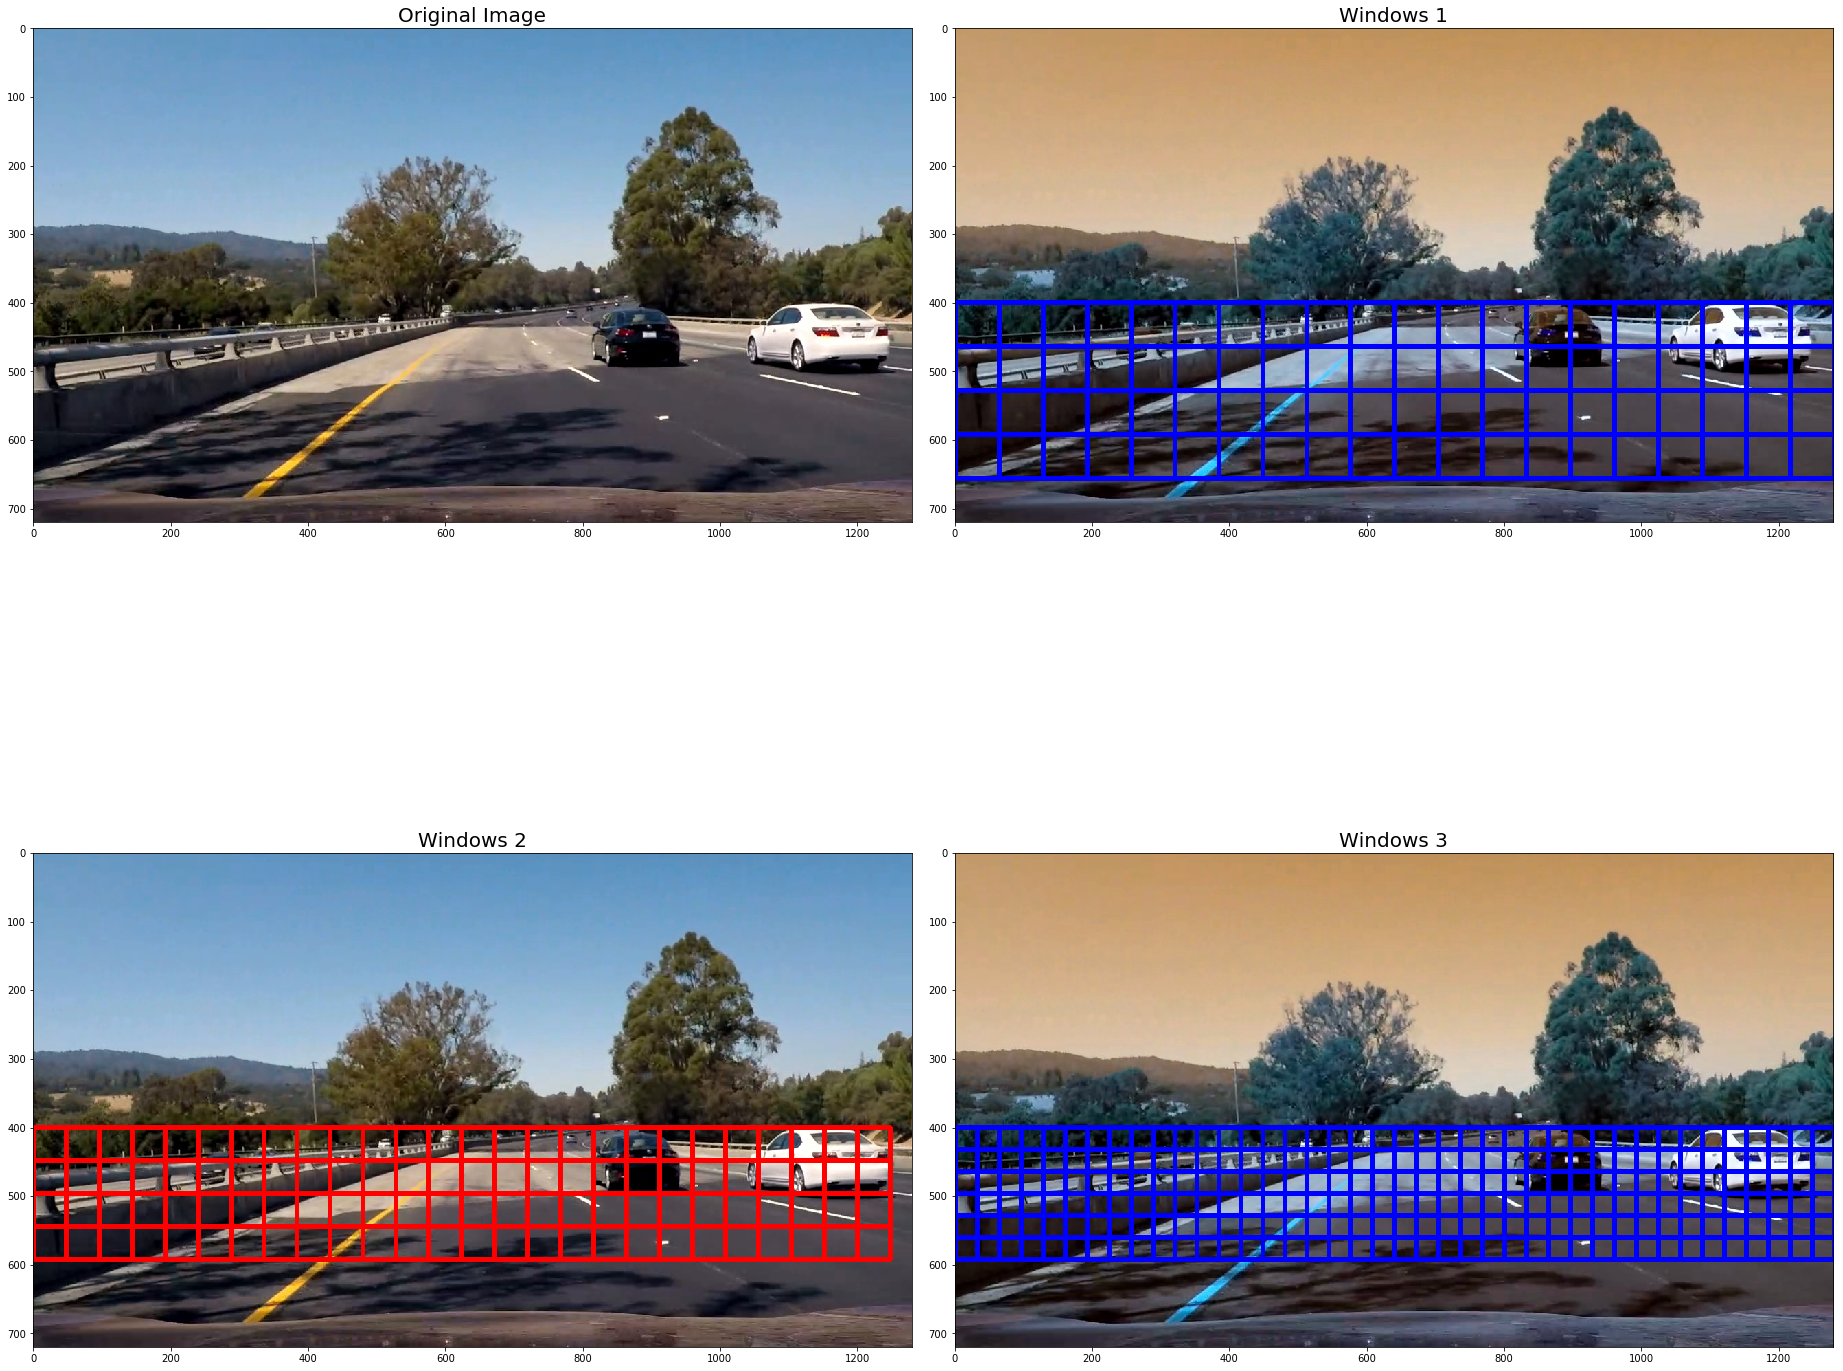

In [105]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = cv2.imread('sample_images/frame31.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,684], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,592], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,592], 
                   xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windowsnew = []
for win in windows:
    windowsnew.append(win)
for win in windows1:
    windowsnew.append(win)
for win in windows2:
    windowsnew.append(win)

draw_image = np.copy(image)
window_img = draw_boxes(draw_image, windowsnew, color=(0, 0, 255), thick=6) 
window_img1 = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(draw_image, windows1, color=(0, 0, 255), thick=6)
window_img3 = draw_boxes(draw_image, windows2, color=(0, 0, 255), thick=6)

f, ax = plt.subplots(2, 2, figsize=(25,25))
f.tight_layout()
ax[0][0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax[0][0].set_title('Original Image', fontsize=20)
ax[0][1].imshow(window_img1, cmap='gray')
ax[0][1].set_title('Windows 1', fontsize=20)

ax[1][0].imshow(cv2.cvtColor(window_img2,cv2.COLOR_BGR2RGB))
ax[1][0].set_title('Windows 2', fontsize=20)
ax[1][1].imshow(window_img3, cmap='gray')
ax[1][1].set_title('Windows 3', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(save_path + 'windows.jpg')

In [103]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = cv2.imread('sample_images/frame31.jpg')
hot_windows = search_windows(image, windowsnew, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       


/Users/carnot/Public/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


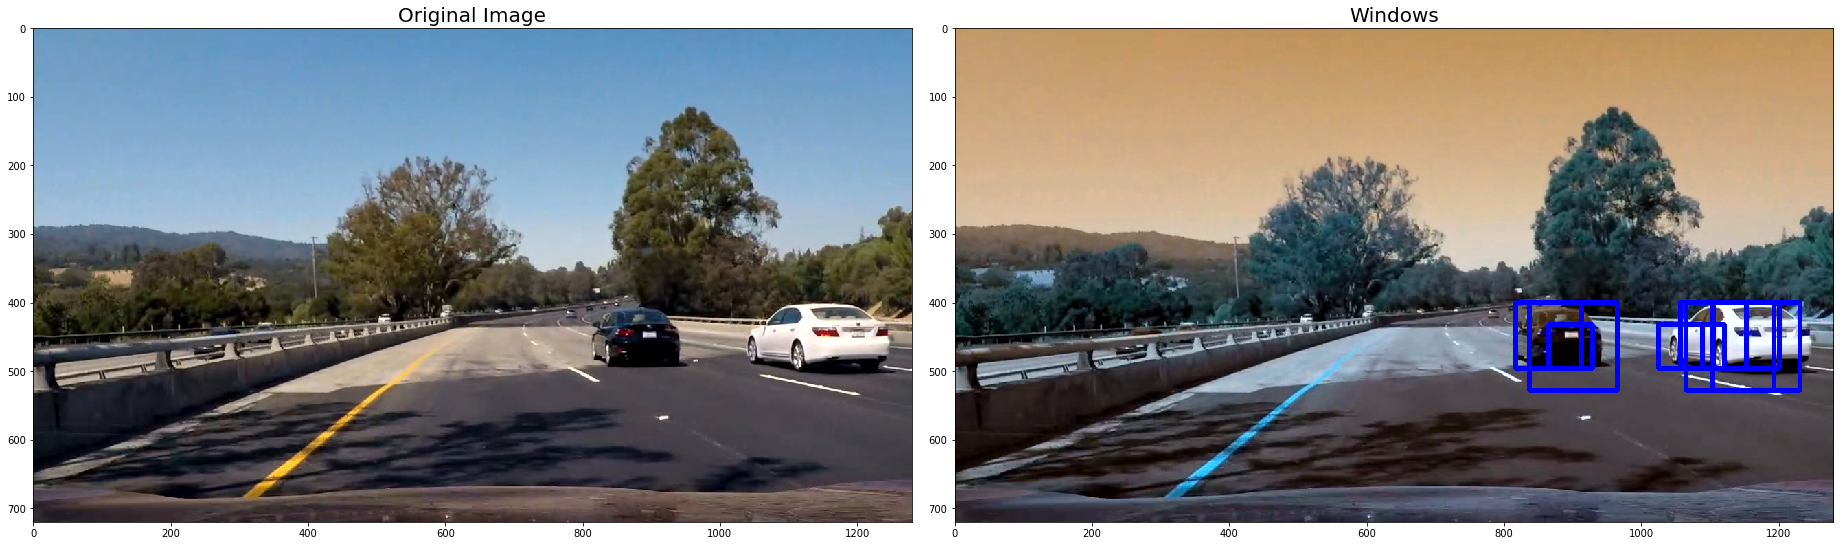

In [104]:
draw_image = np.copy(image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
f, ax = plt.subplots(1, 2, figsize=(25,25))
f.tight_layout()
ax[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(window_img, cmap='gray')
ax[1].set_title('Windows', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(save_path + 'hot_windows.jpg')

## 4. Labels

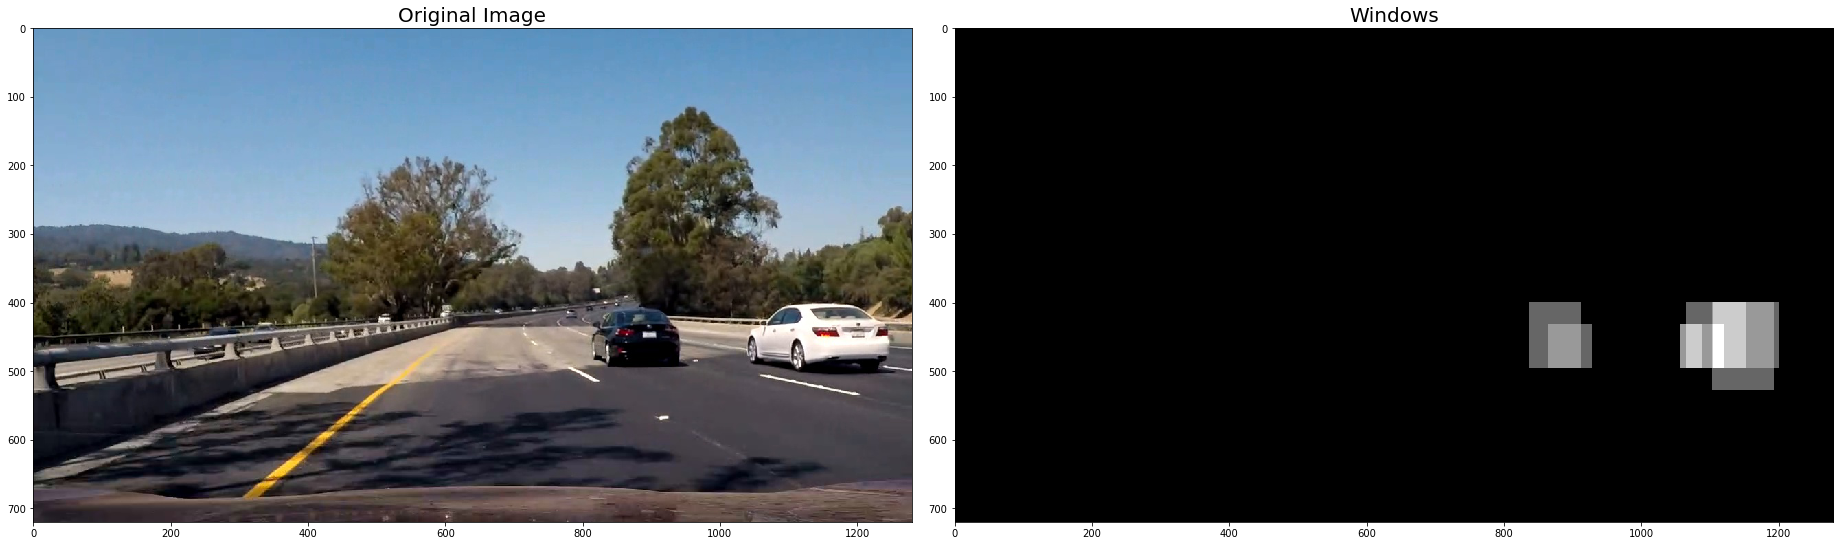

In [106]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

f, ax = plt.subplots(1, 2, figsize=(25,25))
f.tight_layout()
ax[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(heatmap, cmap='gray')
ax[1].set_title('Windows', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(save_path + 'label_windows.jpg')

## 5.Final Draw

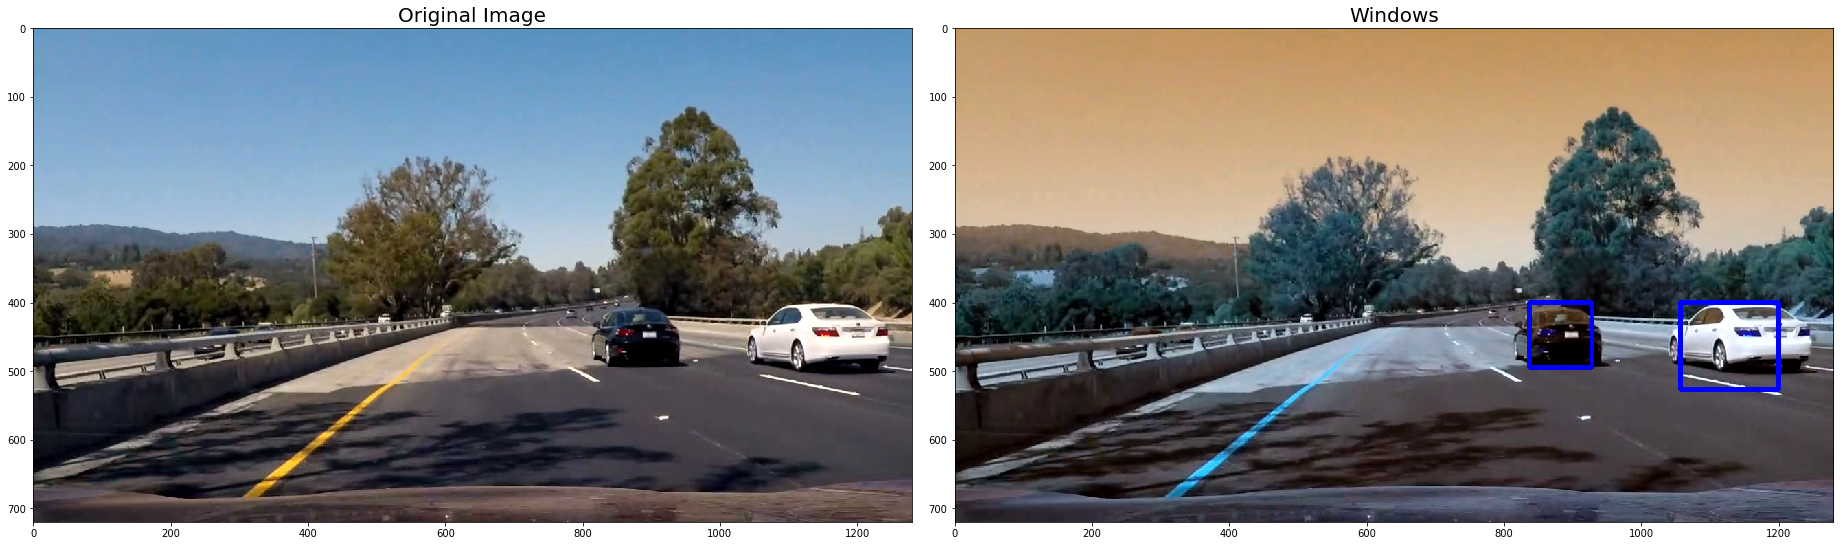

In [101]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

draw_img = draw_labeled_bboxes(np.copy(image), labels)
f, ax = plt.subplots(1, 2, figsize=(25,25))
f.tight_layout()
ax[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(draw_img)
ax[1].set_title('Windows', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(save_path + 'final_image.jpg')